# 1. First we load the data we want to run with: which is the TGRFs

In [2]:
pip install "numpy<2"

Note: you may need to restart the kernel to use updated packages.


In [1]:
from Reduced_functions import *
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os
#from ssim import SSIM
import seaborn as sns
import torch
import torchvision
import pandas as pd
from IQA_pytorch import SSIM, MS_SSIM
from scipy.spatial import distance
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter

In [2]:
def compute_mse(array1, array2):
    # Check if the arrays are the same shape, if not, return None
    if array1.shape != array2.shape:
        return np.nan
    # Convert the arrays to PyTorch tensors
    array1 = torch.from_numpy(array1)
    array2 = torch.from_numpy(array2)

    # Compute the MSE between the two arrays
    mse_loss = torch.nn.MSELoss()
    score = mse_loss(array1.float(), array2.float())

    return score.item()

def compute_ssim(array1, array2):
    # Check if the arrays are the same shape, if not, return None
    if array1.shape != array2.shape:
        return np.nan
    # Convert the arrays to PyTorch tensors
    array1 = torch.from_numpy(array1)
    array2 = torch.from_numpy(array2)

    # Ensure the tensors are floating point
    array1 = array1.float()
    array2 = array2.float()

    # Add two extra dimensions to the tensors to represent the batch size and the number of channels
    array1 = array1.unsqueeze(0).unsqueeze(0)
    array2 = array2.unsqueeze(0).unsqueeze(0)

    # Create an SSIM object
    ssim = SSIM()

    # Compute the SSIM between the two arrays
    score = ssim(array1, array2)

    return score.item()

def compute_msssim(array1, array2):
    # Check if the arrays are the same shape, if not, return None
    if array1.shape != array2.shape:
        return np.nan
    # Convert the arrays to PyTorch tensors
    array1 = torch.from_numpy(array1)
    array2 = torch.from_numpy(array2)

    # Ensure the tensors are floating point
    array1 = array1.float()
    array2 = array2.float()

    # Add two extra dimensions to the tensors to represent the batch size and the number of channels
    array1 = array1.unsqueeze(0).unsqueeze(0)
    array2 = array2.unsqueeze(0).unsqueeze(0)

    # Create an MS_SSIM object
    ms_ssim = MS_SSIM()

    # Compute the MS-SSIM between the two arrays
    score = ms_ssim(array1, array2)

    return score.item()

In [3]:
os.chdir('..')
os.chdir('Data')

In [4]:
# Load low-resolution
#low_res = np.load('small_resolutions.npy')
# Load medium resolution
med_res = np.load('medium_resolutions.npy')
# Load high resolution
high_res = np.load('large_resolutions.npy')
# Load huge resolution
huge_res = np.load('extra_large_resolutions.npy')
all_data = [ med_res, high_res, huge_res]

# 2. Then we plot all the data

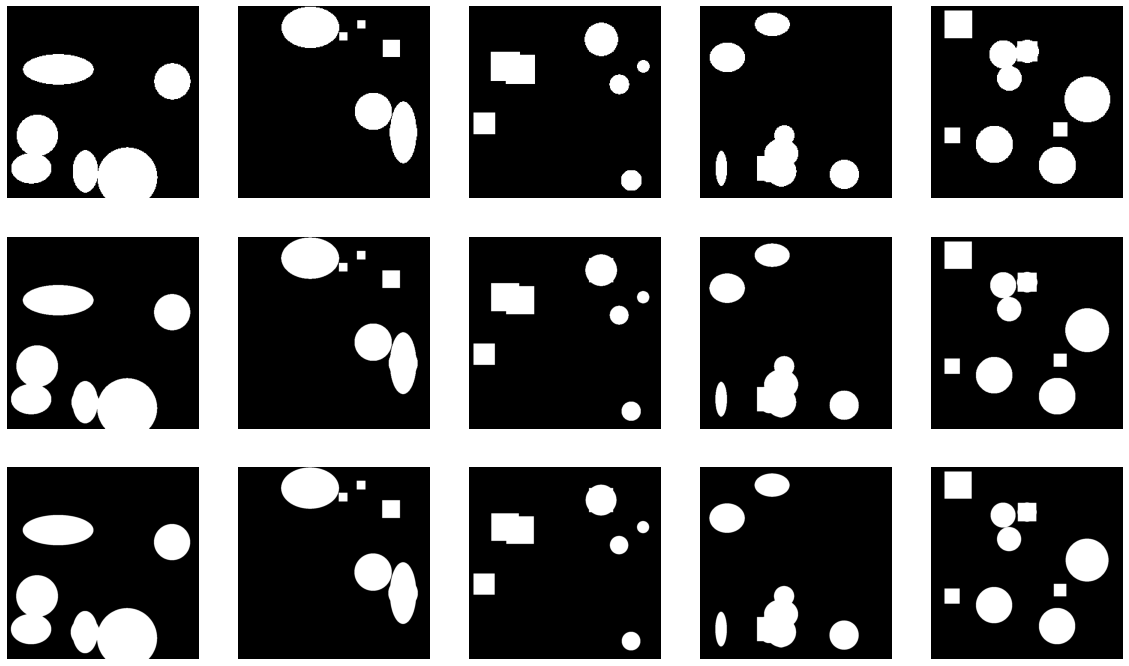

In [5]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for j in range(len(all_data)):
    for i in range(5):
        axes[j, i].imshow(all_data[j][i], cmap='gray')
        axes[j, i].axis('off')
plt.show()

In [6]:
def calculate_statistics(counts):
    mean_count = np.mean(counts)
    var_count = np.var(counts)
    return mean_count, var_count

def count_ones_in_subgrids(binary_array, subgrid_ratio=0.10):
    rows, cols = binary_array.shape
    total_subgrid_row = int(subgrid_ratio * rows)
    total_subgrid_col = int(subgrid_ratio * cols)
    counts = []
    for i in range(0, rows, total_subgrid_row):
        for j in range(0, cols, total_subgrid_col):
            subgrid = binary_array[i:i+total_subgrid_row, j:j+total_subgrid_col]
            counts.append(np.sum(subgrid))
    return np.array(counts), total_subgrid_row, total_subgrid_col

def construct_metric(binary_array, subgrid_ratio=0.10):
    counts, total_subgrid_row, total_subgrid_col = count_ones_in_subgrids(binary_array, subgrid_ratio)
    mean_count, var_count = calculate_statistics(counts)
    
    # Expected mean and variance for a random distribution
    total_cells = total_subgrid_row * total_subgrid_col
    p = np.mean(binary_array)  # Proportion of 1s in the entire array
    expected_mean = total_cells * p
    expected_variance = total_cells * p * (1 - p)
    
    # Normalize the variance to be between -1 and 1
    metric = (var_count - expected_variance) / (var_count + expected_variance)
    # normalize the variance again to be between 0 and 1
    metric = (metric + 1) / 2
    
    return metric

def gridposition_to_coordinate(grid_position, grid_size, image_size = 1000):
    # Compute the size of the grid cells
    grid_cell_size = image_size / grid_size

    # Compute the x and y coordinates of the grid cell
    x = grid_position[0] * grid_cell_size 
    y = grid_position[1] * grid_cell_size 

    return x, y

def custom_distance_transform(array, image_size=1000):
    # Compute the Euclidean distance transform on the grid
    grid_distances = distance_transform_edt(array)
    
    # Convert grid distances to real-world coordinates by scaling
    grid_size = array.shape[0]
    grid_cell_size = image_size / grid_size
    real_distances = grid_distances * grid_cell_size
    
    return real_distances

def custom_anchors(image,base_size,arrays=False):
    mindist = minimum_distance_transform(image)
    locmin = local_maxima(mindist)
    anchors = np.zeros(image.shape)
    anchor_radii = np.zeros(image.shape)
    anchor_label = np.zeros(image.shape)
    indices = np.where(image == 1)
    coordinates = list(zip(indices[0], indices[1]))
    distances = mindist[indices]
    connectivity = generate_binary_structure(2, 2)
    labeled_array, num_features = label(image, structure=connectivity)

    # Sort coordinates by distances in descending order
    sorted_coords = [coord for _, coord in sorted(zip(distances, coordinates), reverse=True, key=lambda x: x[0])]
    # Initialize KD-Tree with the first point
    anchors[sorted_coords[0]] = 1
    anchor_radii[sorted_coords[0]] = mindist[sorted_coords[0]]
    anchor_label[sorted_coords[0]] = labeled_array[sorted_coords[0]]
    anchor_tree = KDTree([sorted_coords[0]])

    # Iterate over sorted coordinates
    for i in range(1, len(sorted_coords)):
        point = sorted_coords[i]
        if locmin[point] == 1:  # Check if the point is a local minimum
            distance, _ = anchor_tree.query(point)
            if distance >= mindist[point]:  # Compare distance to the nearest anchor
                anchors[point] = 1
                anchor_radii[point] = mindist[point]
                anchor_label[point] = labeled_array[point]
                anchor_tree = KDTree(np.vstack([anchor_tree.data, point]))  # Update KD-Tree with new anchor
    
    anchor_coordinates = np.argwhere(anchors)
    anchor_coord = np.array([np.flip(np.array(gridposition_to_coordinate(choord, image.shape[0],base_size))) for choord in anchor_coordinates])
    if arrays:
        return anchors, anchor_radii, anchor_label
    else:
        return anchor_coord, (anchor_radii[anchor_radii!=0]*base_size/image.shape[0]), anchor_label[anchor_label!=0]

def supervector(image):
    supervector = np.zeros(4)
    anchors, radii, labels = custom_anchors(image, 1000, arrays=True)
    # First feature is the sum of the radius of the anchor points divided by the number of grid cells
    supervector[0] = np.sum(radii**2) / (image.shape[0]*image.shape[1])
    # Second is the number of objects divided by the number of grid cells
    nr_of_objects = int(np.max(labels))
    supervector[1] = nr_of_objects 
    # Third is the number of anchor points per object divided by the total area of the object
    contribution = np.zeros(nr_of_objects)
    for i in range(nr_of_objects):
        object_cells = np.where(labels == i+1)
        nr_of_anchors_in_object = len(object_cells[0])
        sum_of_radii = np.sum(radii[object_cells]**2) / np.sum(radii**2)
        contribution[i] = nr_of_anchors_in_object 
    supervector[2] = np.mean(contribution)
    # Fourth is the custom metric
    supervector[3] = construct_metric(anchors)
    return supervector

def expected_nearest_neighbor_distance(n_points, area):
    # Expected nearest neighbor distance in a Poisson random distribution
    return 1 / (2 * np.sqrt(n_points / area))

def compute_metric(coordinates, k, base_size=1000):
    # Number of points
    n_points = len(coordinates)

    # Calculate total area of the grid
    total_area = base_size**2

    # Calculate the expected nearest neighbor distance
    r_expected = expected_nearest_neighbor_distance(n_points, total_area)

    # Compute the search radius as a multiple of the expected nearest neighbor distance
    search_radius = k * r_expected

    # Calculate point density
    point_density = n_points / total_area

    # Expected number of points in the search radius area
    search_area = np.pi * search_radius**2
    expected_count = point_density * search_area

    # Build KDTree for fast radius-based searches
    tree = KDTree(coordinates)

    # Get the number of points within the search radius for each point
    counts = []
    for point in coordinates:
        indices = tree.query_ball_point(point, search_radius)
        count = len(indices) - 1  # Exclude the point itself
        counts.append(count)

    # Compute the empirical mean and variance of the counts
    counts = np.array(counts)
    empirical_mean = np.mean(counts)
    empirical_variance = np.var(counts)

    # Theoretical variance for a Poisson distribution (equals the mean)
    theoretical_variance = expected_count

    # Compute the metric (empirical variance - theoretical variance) / (empirical variance + theoretical variance)
    if empirical_variance + theoretical_variance > 0:
        metric = (empirical_variance - theoretical_variance) / (empirical_variance + theoretical_variance)
    else:
        metric = 0

    return metric

def disjoint_subregion_variance_measure(coordinates,base_size,subgrid_size=10):
    number_of_points = len(coordinates)
    theoretical_variance = number_of_points / subgrid_size**2
    # Count the number of points in each subregion
    counts = np.zeros((subgrid_size, subgrid_size))
    for point in coordinates:
        x, y = point
        i = int(x // (base_size / subgrid_size))
        j = int(y // (base_size / subgrid_size))
        if i == subgrid_size:
            i -= 1
        if j == subgrid_size:
            j -= 1
        counts[i, j] += 1
    empirical_variance = np.var(counts)
    measure = 1 / (1 + theoretical_variance/empirical_variance)
    return measure

def feature_vector(image, base_size):
    supervector = np.zeros(4)
    anchors, radii, labels = custom_anchors(image, base_size)
    # Set k to be 1/10th of the anchor length
    k = 5
    # First feature is the number of anchor points
    supervector[0] = len(anchors)
    # Second is the sum of the radius of the anchor points divided by the base size area
    supervector[1] = np.sum(radii) / base_size**2
    #Third is the average number of anchor points per object
    nr_of_objects = int(np.max(labels))
    contribution = np.zeros(nr_of_objects)
    for i in range(nr_of_objects):
        object_cells = np.where(labels == i+1)
        nr_of_anchors_in_object = len(object_cells[0])
        contribution[i] = nr_of_anchors_in_object
    supervector[2] = np.mean(contribution)
    # Fourth is a custom metric
    supervector[3] = disjoint_subregion_variance_measure(anchors, base_size)
    return supervector

In [7]:
# Example structure of how custom_anchors outputs have changed
# all_anchors now contains:
# 1. array of coordinates for the ones
# 2. array of values at those coordinates (radii)
# 3. array of values at those coordinates (for color mapping)
base_size = all_data[0][0].shape[0]

all_anchors_array = []
for data in all_data:
    anchors = []
    for i in range(len(data)):
        anchors.append(custom_anchors(data[i], base_size,True))  # Updated custom_anchors function
    all_anchors_array.append(anchors)


all_anchors = []
for data in all_data:
    anchors = []
    for i in range(len(data)):
        anchors.append(custom_anchors(data[i], base_size))  # Updated custom_anchors function
    all_anchors.append(anchors)

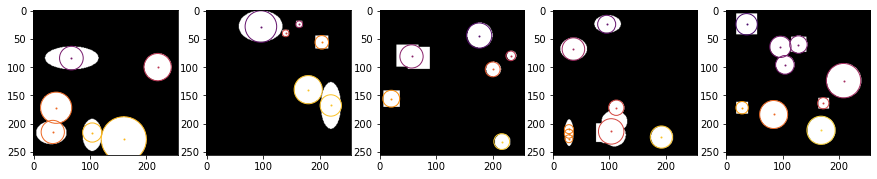

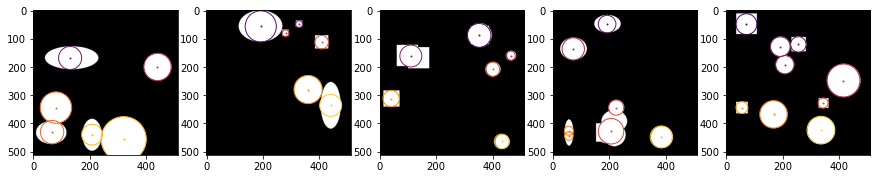

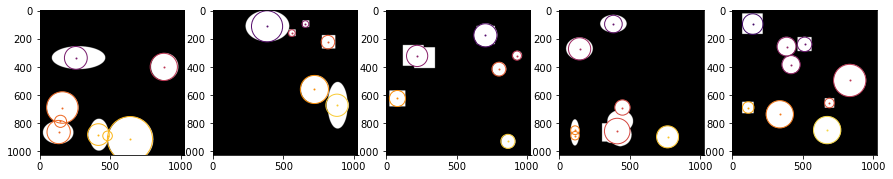

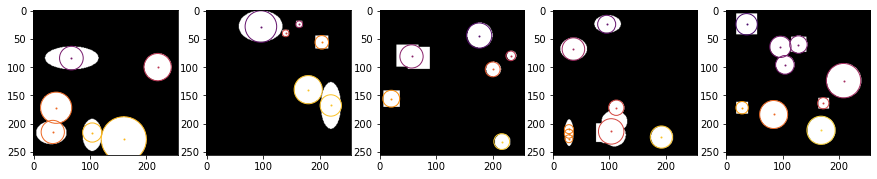

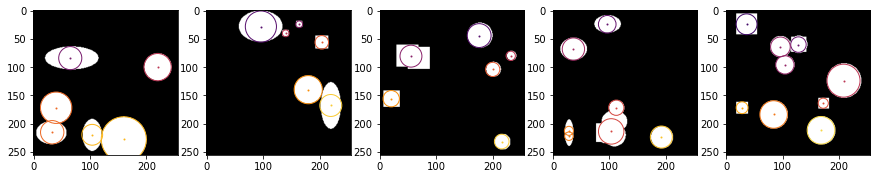

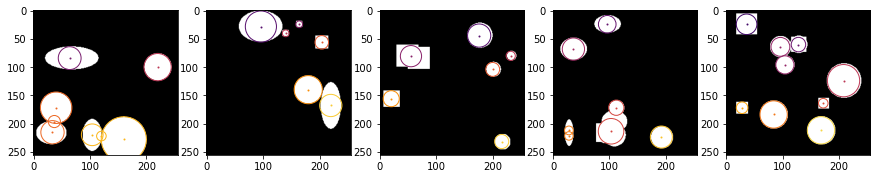

In [8]:
# Let the color be determined by the label of the anchor point
for j in range(len(all_data)):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        nr_anchor_points = np.sum(all_anchors_array[j][i][0])
        ax[i].imshow(all_data[j][i], cmap='gray')
        colors = sns.color_palette('inferno', int(np.max(all_anchors_array[j][i][2])) + 1)
        for k in range(int(nr_anchor_points)):
            x, y = np.where(all_anchors_array[j][i][0])[0][k], np.where(all_anchors_array[j][i][0])[1][k]
            r = all_anchors_array[j][i][1][x, y]
            ax[i].plot(y, x, 'o', markersize=1, color=colors[int(all_anchors_array[j][i][2][x, y])])
            circle = plt.Circle((y, x), r, color=colors[int(all_anchors_array[j][i][2][x, y])], fill=False)
            ax[i].add_artist(circle)
    plt.show()

# Plot each dataset
for j in range(len(all_data)):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))  # Adjusting the figure to 5 subplots
    for i in range(5):
        # Clear the axes before adding new points and circles
        ax[i].cla()  # Clear the axes to remove previous points and circles
        
        # Unpack the custom_anchors output for each data point
        coords = all_anchors[j][i][0]  # Coordinates of the anchor points
        radii = all_anchors[j][i][1]   # Radii at those coordinates
        colors_vals = all_anchors[j][i][2]  # Values for coloring
        
        # Plot the underlying data (grayscale image)
        ax[i].imshow(all_data[0][i], cmap='gray')  # Intentional use of all_data[0]
        
        # Create a color palette based on the unique values in colors_vals
        colors = sns.color_palette('inferno', int(np.max(colors_vals)) + 1)
        
        # Loop through the anchor points and plot them
        for k in range(len(coords)):  # Loop through all the anchor points
            x, y = coords[k]  # Get the x, y coordinates of the anchor point
            r = radii[k]  # Get the radius value at that point
            color_idx = int(colors_vals[k])  # Get the color index for that point
            
            # Plot the anchor point (marker)
            ax[i].plot(x, y, 'o', markersize=1, color=colors[color_idx])  # x and y reversed for plotting
            
            # Add a circle around the anchor point with radius `r`
            circle = plt.Circle((x, y), r, color=colors[color_idx], fill=False)  # Note: (y, x) for correct positioning
            ax[i].add_artist(circle)
    
    plt.show()

In [9]:
# Compute and print the supervector on the first image of each dataset
super_vectors_old = []
for i in range(len(all_data)):
    super_vec = []
    for j in range(len(all_data[i])):
        super_vec.append(supervector(all_data[i][j]))
    super_vectors_old.append(super_vec)

super_vectors_new = []
for i in range(len(all_data)):
    super_vec = []
    for j in range(len(all_data[i])):
        super_vec.append(feature_vector(all_data[i][j], base_size))
    super_vectors_new.append(super_vec)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Define the function for plotting line plots of the supervector features using matplotlib
def histogram_plot_with_kde(all_vecs, labels, datanames, colors):
    super_vecs = np.asarray(all_vecs)
    print(f"super_vecs shape: {super_vecs.shape}")  # Debug print

    # Create subplots for each feature (third dimension of super_vecs)
    fig, axes = plt.subplots(1, super_vecs.shape[2], figsize=(40, 10))

    # Flatten axes array in case it's multidimensional
    axes = np.atleast_1d(axes).flatten()

    # Iterate through each feature (third dimension of super_vecs)
    for i in range(super_vecs.shape[2]):
        for j in range(super_vecs.shape[0]):
            # Extract the j-th vector for the i-th feature
            super_vec = np.asarray(super_vecs[j, :, i]).flatten()

            # Debug print the shape and dtype of the super_vec
            print(f"super_vec shape for dataname {datanames[j]} in feature {i}: {super_vec.shape}, dtype: {super_vec.dtype}")

            # Create KDE-like smoothed lines using gaussian_kde
            kde = gaussian_kde(super_vec)
            x_range = np.linspace(np.min(super_vec), np.max(super_vec), 100)
            kde_values = kde(x_range)

            # Plot smoothed line
            axes[i].plot(x_range, kde_values, label=datanames[j], color=colors[j])

        # Customize each subplot
        axes[i].set_title(labels[i],fontsize=30)
        axes[i].set_xlabel('Value',fontsize=30)
        axes[i].set_ylabel('Frequency',fontsize=30)
        axes[i].legend()

    plt.show()


super_vecs shape: (3, 50, 4)
super_vec shape for dataname Low resolution in feature 0: (50,), dtype: float64
super_vec shape for dataname Medium resolution in feature 0: (50,), dtype: float64
super_vec shape for dataname High resolution in feature 0: (50,), dtype: float64
super_vec shape for dataname Low resolution in feature 1: (50,), dtype: float64
super_vec shape for dataname Medium resolution in feature 1: (50,), dtype: float64
super_vec shape for dataname High resolution in feature 1: (50,), dtype: float64
super_vec shape for dataname Low resolution in feature 2: (50,), dtype: float64
super_vec shape for dataname Medium resolution in feature 2: (50,), dtype: float64
super_vec shape for dataname High resolution in feature 2: (50,), dtype: float64
super_vec shape for dataname Low resolution in feature 3: (50,), dtype: float64
super_vec shape for dataname Medium resolution in feature 3: (50,), dtype: float64
super_vec shape for dataname High resolution in feature 3: (50,), dtype: flo

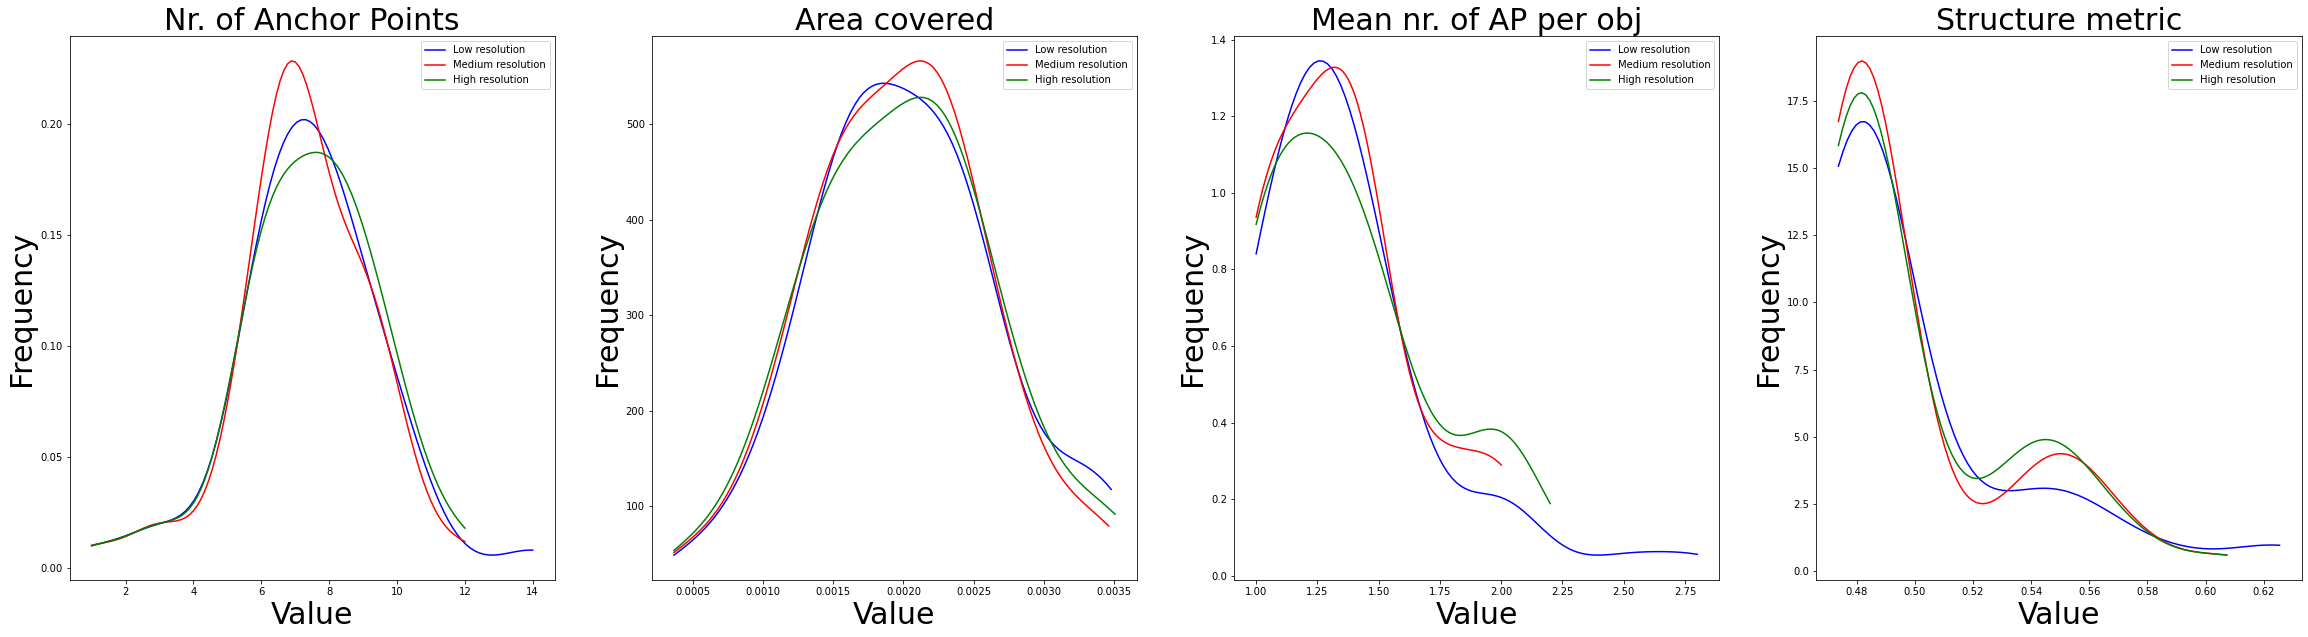

In [33]:
labels = ['Nr. of Anchor Points', 'Area covered', 'Mean nr. of AP per obj', 'Structure metric']
datanames = ['Low resolution', 'Medium resolution', 'High resolution', 'Huge resolution']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']
histogram_plot_with_kde(super_vectors_new,labels,datanames,some_colors)

In [1]:
# Plot the same feature on each axis with the picture as dots
def scatter_plot(all_vecs,labels):
    super_vecs = np.array(all_vecs)
    fig, axes = plt.subplots(1, super_vecs.shape[2], figsize=(40, 10))
    for i in range(super_vecs.shape[2]):
        axes[i].scatter(super_vecs[0, :, i], super_vecs[2, :, i], color='red', label='Low vs high resolution')
        axes[i].set_xlim([np.min(super_vecs[:,:,i]), np.max(super_vecs[:,:,i])])
        axes[i].set_ylim([np.min(super_vecs[:,:,i]), np.max(super_vecs[:,:,i])])
        # Plot a diagonal line
        axes[i].plot([np.min(super_vecs[:,:,i]), np.max(super_vecs[:,:,i])], [np.min(super_vecs[:,:,i]), np.max(super_vecs[:,:,i])], 'k--')
        axes[i].set_xlabel('Low resolution')
        axes[i].set_ylabel('High resolution')
        axes[i].set_title(labels[i])
    plt.show()

In [ ]:
scatter_plot(super_vectors_new,labels)

In [14]:
def plotting_vecs(all_vecs,labels,datanames,some_colors,subplot_dim):
    fig, axes = plt.subplots(subplot_dim, subplot_dim, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    # Plot the data in matrix form
    for i in range(subplot_dim):
        for j in range(subplot_dim):
            if i == j:
                for k in range(len(all_vecs)):
                    axes[i, j].hist(np.array(all_vecs[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                    # use log scale for the y-axis
                    #axes[i, j].set_yscale('log')
                    # Set x-axis to be between 0 and max value
                    #axes[i, j].set_xlim(0, np.max(np.array(all_vecs[k])[:,i]))
                    #axes[i, j].legend()
            else:
                for k in range(len(all_vecs)):
                    axes[i, j].scatter(np.array(all_vecs[k])[:,j], np.array(all_vecs[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                    # Set ticks to have only 3 decimal places
                    axes[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                    #axes[i, j].legend()
            if i == 3:
                axes[i, j].set_xlabel(labels[j])
            if j == 0:
                axes[i, j].set_ylabel(labels[i])

    # Create a new figure for the legend
    fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

    # Create legend handles manually
    handles = [mpatches.Patch(color=some_colors[i], label=datanames[i]) for i in range(len(datanames))]

    # Add the legend to the subplot
    ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

    # Hide the axes
    ax_legend.axis('off')

    # Show the plots
    plt.show()

In [24]:
np.save('super_vectors_resolution.npy',super_vectors_old)
np.save('super_vectors_new_resolution.npy',super_vectors_new)

In [ ]:
labels = ['Total radii', 'Nr of objects', 'Mean nr. of AP per obj', 'Structure metric']
datanames = ['Low resolution', 'Medium resolution', 'High resolution', 'Huge resolution']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']
subplot_dim = 4
plotting_vecs(super_vectors_old,labels,datanames,some_colors,subplot_dim)

In [ ]:
labels = ['Nr. of Anchor Points', 'Area covered', 'Mean nr. of AP per obj', 'Structure metric']
datanames = ['Low resolution', 'Medium resolution', 'High resolution', 'Huge resolution']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']
subplot_dim = 4
plotting_vecs(super_vectors_new,labels,datanames,some_colors,subplot_dim)

In [27]:
def euclidean_distance_norm(v1, v2):
    dimension = len(v1)
    return 1 - (np.linalg.norm(v1 - v2) / np.sqrt(dimension))

def comparison(vec1,vec2):
    comp = []
    for i in range(len(vec1)):
        calc = 1 - ((vec1[i]-vec2[i])**2/np.max([vec1[i],vec2[i],vec1[i]-vec2[i]])**2)
        comp.append(calc)
    comp = np.array(comp)
    return np.mean(comp)

In [ ]:
super_vec_comparisons = []
super_vec_new_comparisons = []
mse_comparisons = []
ssim_comparisons = []
msssim_comparisons = []
for i in range(len(super_vectors_old)):
    super_veccy_comp = []
    super_veccy_new_comp = []
    mse_comp = []
    ssim_comp = []
    msssim_comp = []
    for j in range(len(super_vectors_old)):
        super_vec_comp = []
        super_vec_new_comp = []
        mse_comp_inner = []
        ssim_comp_inner = []
        msssim_comp_inner = []
        for k in range(50):
                super_vec_comp.append(comparison(super_vectors_old[i][0],super_vectors_old[j][k]))
                super_vec_new_comp.append(comparison(super_vectors_new[i][0],super_vectors_new[j][k]))
                mse_comp_inner.append(compute_mse(all_data[i][0],all_data[j][k]))
                ssim_comp_inner.append(compute_ssim(all_data[i][0],all_data[j][k]))
                msssim_comp_inner.append(compute_msssim(all_data[i][0],all_data[j][k]))
        super_veccy_comp.append(super_vec_comp)
        super_veccy_new_comp.append(super_vec_new_comp)
        mse_comp.append(mse_comp_inner)
        ssim_comp.append(ssim_comp_inner)
        msssim_comp.append(msssim_comp_inner)
    super_vec_comparisons.append(super_veccy_comp)
    super_vec_new_comparisons.append(super_veccy_new_comp)
    mse_comparisons.append(mse_comp)
    ssim_comparisons.append(ssim_comp)
    msssim_comparisons.append(msssim_comp)

In [ ]:
super_vec_comparisons = np.array(super_vec_comparisons)
super_vec_new_comparisons = np.array(super_vec_new_comparisons)
mse_comparisons = np.array(mse_comparisons)
ssim_comparisons = np.array(ssim_comparisons)
msssim_comparisons = np.array(msssim_comparisons)

# Assuming you have 5 arrays: super_vec_comparisons, super_vec_new_comparisons, mse_comparisons, ssim_comparisons, msssim_comparisons

# Convert arrays to np.array and replace None with np.nan
arrays = [super_vec_comparisons, super_vec_new_comparisons, mse_comparisons, ssim_comparisons, msssim_comparisons]
#arrays = [np.where(arr == None, np.nan, arr) for arr in arrays]

# Generate the correct Pair labels, ensuring it matches the (3, 3, 50) shape
pair_labels = [f'{i+1}-{j+1}' for i in range(3) for j in range(3) for _ in range(50)]

# Flatten the arrays and create DataFrames with corresponding metric names
df_super_vec = pd.DataFrame({'Value': super_vec_comparisons.flatten(), 'Pair': pair_labels, 'Metric': 'PointSSIM'})
df_super_vec_new = pd.DataFrame({'Value': super_vec_new_comparisons.flatten(), 'Pair': pair_labels, 'Metric': 'PointSSIM'})
df_mse = pd.DataFrame({'Value': mse_comparisons.flatten(), 'Pair': pair_labels, 'Metric': 'MSE'})
df_ssim = pd.DataFrame({'Value': ssim_comparisons.flatten(), 'Pair': pair_labels, 'Metric': 'SSIM'})
df_msssim = pd.DataFrame({'Value': msssim_comparisons.flatten(), 'Pair': pair_labels, 'Metric': 'MS-SSIM'})

# Combine all DataFrames into one
df_combined = pd.concat([df_super_vec_new, df_mse, df_ssim, df_msssim])

# Custom color palette for each Metric
palette = ['blue', 'orange', 'green', 'red', 'purple']

# Custom titles for datasets
dataset_titles = ['Low Resolution', 'Medium Resolution', 'High Resolution']

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plot side-by-side violins for each pair in the 3x3 grid, with y-axis limit [0,1]
for i in range(3):
    for j in range(3):
        pair_data = df_combined[df_combined['Pair'] == f'{i+1}-{j+1}'].dropna(subset=['Value'])
        sns.violinplot(x='Metric', y='Value', data=pair_data, ax=axs[i, j], hue='Metric', palette=palette, legend=False, inner='point')
        axs[i, j].set_ylim(0, 1)  # Set y-axis limits to be between 0 and 1
        axs[i, j].set_title(f'Comparison: {dataset_titles[i]} vs {dataset_titles[j]}')

# Show the plot
plt.tight_layout()
plt.show()